# Feature Analysis for GDLC

This notebook focuses on analyzing various features extracted from network traffic data to identify potential intrusions. Our goal is to understand the significance of each feature in the context of intrusion detection and to select the most relevant features for building a predictive model.

## Data Loading

In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import json
import seaborn as sns

from src.data.dataset_info import datasets
from sklearn.feature_selection import VarianceThreshold

# defining the thresholds
var_threshold = 0.00
corr_threshold = 0.75

# specifying the dataset
dataset = datasets[0]
name = dataset.name
print("dataset: {}".format(name))
path = "./datasets/preprocessed/{}.pkl".format(name)
# graph_path = "./datasets/preprocessed/graph_{}.gexf".format(name)

# loading the dataset as a Pandas dataframe
df = pd.read_pickle(path)

# We are only concerned with features used in training
df.drop(dataset.drop_columns, axis=1, inplace=True)
df.drop(dataset.label_col, axis=1, inplace=True)

dataset: cic_ton_iot


## Variance Thresholding

In [5]:
# Create a VarianceThreshold object
selector = VarianceThreshold(threshold=var_threshold)

# Fit the selector to the data and transform the data
data_filtered = selector.fit_transform(df)

# Get the names of the selected features
selected_features = df.columns[selector.get_support(indices=True)]

dropped_features = [col for col in df.columns if col not in selected_features]

# Create a new DataFrame with the selected features
data_filtered = pd.DataFrame(df, columns=selected_features)

# variances = np.var(df, axis=0)

print(f"==>> dropped_features by VarianceThreshold: {dropped_features}")

==>> dropped_features by VarianceThreshold: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Subflow Bwd Pkts']


## Correlation Thresholding

Text(0.5, 1.0, 'Correlation Matrix Heatmap in dataset cic_ton_iot')

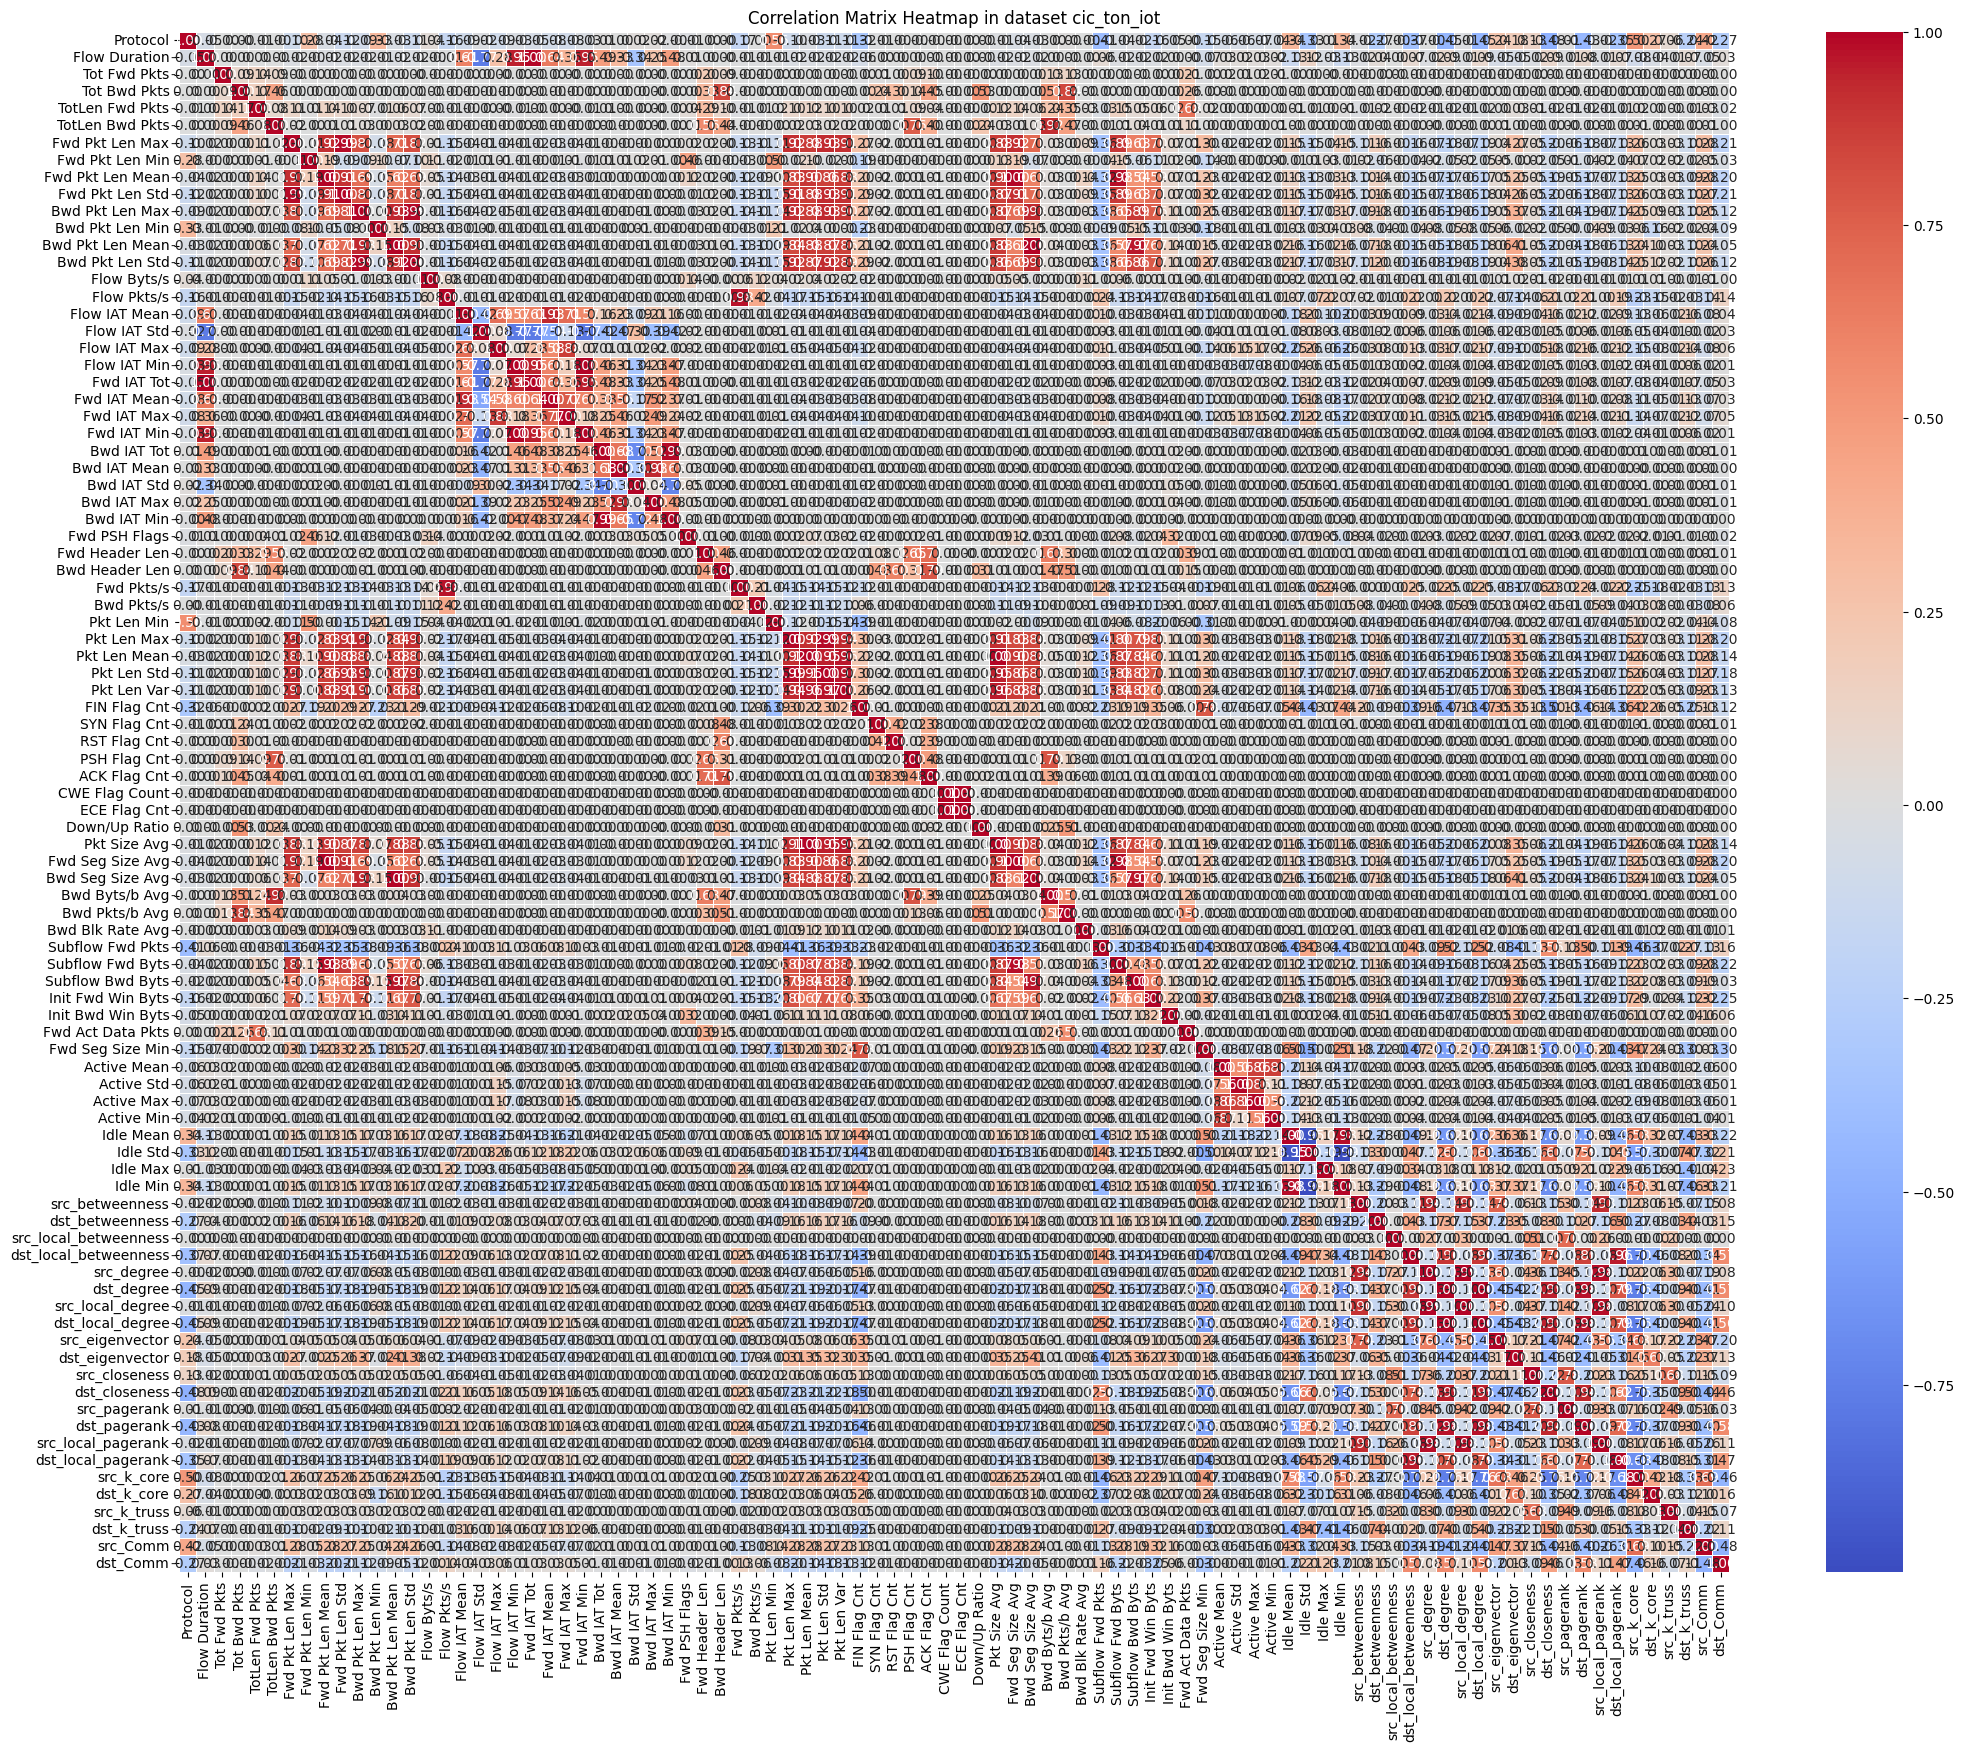

In [6]:
# create the correlation matrix
corr_matrix = data_filtered.corr()

# plotting the heatmap of the matrix
plt.figure(figsize=(25, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
            fmt='.2f', linewidths=.5)  # type: ignore
plt.title("Correlation Matrix Heatmap in dataset {}".format(dataset.name))
# plt.savefig(fname="visualization/{}/correlation_matrix".format(dataset.name))

In [7]:
# getting the top correlated features
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlated_features = [
    column for column in upper.columns if any(upper[column] > corr_threshold)]

# Drop only one feature from each highly correlated pair
features_to_remove = set()
for feature in correlated_features:
    correlated_with_feature = list(
        upper.index[upper[feature] > corr_threshold])
    for correlated_feature in correlated_with_feature:
        if correlated_feature not in features_to_remove:
            features_to_remove.add(correlated_feature)
            # features_to_remove.add(np.random.choice([feature, correlated_feature]))


# Drop the highly correlated features
data_filtered = data_filtered.drop(features_to_remove, axis=1)  # type: ignore

print(f"==>> dropped_features by correlation: {features_to_remove}")

==>> dropped_features by correlation: {'Bwd Pkt Len Std', 'Fwd Pkt Len Mean', 'Flow IAT Mean', 'TotLen Bwd Pkts', 'Pkt Len Std', 'Fwd IAT Tot', 'Bwd IAT Tot', 'Idle Mean', 'Pkt Len Max', 'Bwd Seg Size Avg', 'src_betweenness', 'PSH Flag Cnt', 'FIN Flag Cnt', 'Bwd Pkt Len Mean', 'CWE Flag Count', 'Active Std', 'Active Mean', 'dst_closeness', 'Bwd Pkt Len Max', 'Bwd Header Len', 'dst_local_degree', 'Flow Pkts/s', 'Bwd IAT Mean', 'dst_local_betweenness', 'Flow Duration', 'Pkt Size Avg', 'Fwd Pkt Len Std', 'Pkt Len Mean', 'src_closeness', 'Flow IAT Min', 'dst_degree', 'Pkt Len Var', 'src_local_degree', 'src_degree', 'Fwd Seg Size Avg', 'Fwd IAT Mean', 'Tot Bwd Pkts', 'Flow IAT Max', 'Fwd Pkt Len Max'}


In [8]:
print(f"==>> final_features_names: {list(data_filtered.columns)}")

==>> final_features_names: ['Protocol', 'Tot Fwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Min', 'Bwd Pkt Len Min', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'SYN Flag Cnt', 'RST Flag Cnt', 'ACK Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'dst_betweenness', 'src_local_betweenness', 'src_eigenvector', 'dst_eigenvector', 'src_pagerank', 'dst_pagerank', 'src_local_pagerank', 'dst_local_pagerank', 'src_k_core', 'dst_k_core', 'src_k_truss', 'dst_k_truss', 'src_Comm', 'dst_Comm']


In [9]:
dropped_features.extend(list(features_to_remove))

In [10]:
print(f"==>> length of dropped_features: {len(dropped_features)}")

==>> length of dropped_features: 47


In [11]:
print(f"==>> dropped_features: {dropped_features}")

==>> dropped_features: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Subflow Bwd Pkts', 'Bwd Pkt Len Std', 'Fwd Pkt Len Mean', 'Flow IAT Mean', 'TotLen Bwd Pkts', 'Pkt Len Std', 'Fwd IAT Tot', 'Bwd IAT Tot', 'Idle Mean', 'Pkt Len Max', 'Bwd Seg Size Avg', 'src_betweenness', 'PSH Flag Cnt', 'FIN Flag Cnt', 'Bwd Pkt Len Mean', 'CWE Flag Count', 'Active Std', 'Active Mean', 'dst_closeness', 'Bwd Pkt Len Max', 'Bwd Header Len', 'dst_local_degree', 'Flow Pkts/s', 'Bwd IAT Mean', 'dst_local_betweenness', 'Flow Duration', 'Pkt Size Avg', 'Fwd Pkt Len Std', 'Pkt Len Mean', 'src_closeness', 'Flow IAT Min', 'dst_degree', 'Pkt Len Var', 'src_local_degree', 'src_degree', 'Fwd Seg Size Avg', 'Fwd IAT Mean', 'Tot Bwd Pkts', 'Flow IAT Max', 'Fwd Pkt Len Max']
